# HW5 - Semantic Influence Networks

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git
#All these packages need to be installed from pip
#This will be doing most of the work
import networkx as nx
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## Reading data

In [3]:
reddit_submissions_min= pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)[['author', 'created_utc', 'subreddit', 'title', 'selftext', 'distinguished']]

In [4]:
reddit_submissions_min['created_datetime'] = pandas.to_datetime(reddit_submissions_min['created_utc'], unit='s')

In [28]:
reddit_submissions_min['created_tranche'] = pandas.cut(reddit_submissions_min['created_utc'], bins = 20, labels = list(range(20)))

In [32]:
reddit_submissions_min[reddit_submissions_min['subreddit'] == 'The_Donald']['created_tranche'].value_counts(sort = False)

0        0
1        9
2       64
3      740
4     5724
5     2858
6     3033
7     3410
8     4870
9     3457
10    3357
11    3051
12    3026
13    2729
14    2867
15    3147
16    1809
17    2118
18     797
19    1026
Name: created_tranche, dtype: int64

I'll work with Tranche 8 of the 'r/The_Donald' subreddit.

In [137]:
reddit_submissions_min_select = reddit_submissions_min[(reddit_submissions_min['subreddit'] == 'The_Donald') & (reddit_submissions_min['created_tranche'] == 8)]
reddit_submissions_min_select.head()

author  created_utc   subreddit  \
id                                                      
58cvsk          Daddydante88   1476911906  The_Donald   
58cz8j  -StrangerThanFiction   1476912944  The_Donald   
58czfz             ULTRADETH   1476913006  The_Donald   
58d18m   xXTheCitrusReaperXx   1476913581  The_Donald   
58d1zt         giovanni10487   1476913831  The_Donald   

                                                    title  \
id                                                          
58cvsk  It Is Perfectly Legal For The Media To Lie To ...   
58cz8j  Why doesn't Bernie just endorse Trump and disa...   
58czfz  I'm Canadian and want to watch be debate tonig...   
58d18m                    Is this 4 Chan thing happening?   
58d1zt                           Is michelle obama a man?   

                                                 selftext distinguished  \
id                                                                        
58cvsk  I find it funny that the "most transparent adm...           NaN   
58cz8j  With Trump's new student loan forgiveness and ...           NaN   
58czfz  I have: NBC, CBS, PBS, CNN (yeah right), FOX, ...           NaN   
58d18m  Last night someone said that something Earth-c...           NaN   
58d1zt  I am just hearing about this now. Joan rivers ...           NaN   

          created_datetime created_tranche  
id                                          
58cvsk 2016-10-19 21:18:26               8  
58cz8j 2016-10-19 21:35:44               8  
58czfz 2016-10-19 21:36:46               8  
58d18m 2016-10-19 21:46:21               8  
58d1zt 2016-10-19 21:50:31               8

In [138]:
print("Min date in Tranche 9: {}, Max date in Tranche 8: {}".format(min(reddit_submissions_min_select['created_datetime']), max(reddit_submissions_min_select['created_datetime'])))  

Min date in Tranche 9: 2016-10-19 21:18:26, Max date in Tranche 8: 2016-12-21 13:28:14


In [139]:
reddit_submissions_min_select['post_text'] = reddit_submissions_min_select['title'] + " " + reddit_submissions_min_select['selftext']
reddit_submissions_min_select['tokenized_sents'] = reddit_submissions_min_select['post_text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
reddit_submissions_min_select['normalized_sents'] = reddit_submissions_min_select['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mathew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [140]:
with open('reddit_submissions_min_select_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min_select, f)

## Exercise 1 - 

In [3]:
with open('reddit_submissions_min_select_tkns.pkl', 'rb') as f:
    reddit_submissions_min_select = pickle.load(f)
    
with open('reddit_select_2modenet.pkl', 'rb') as f:
    g_2mode = pickle.load(f)
    
g = nx.read_graphml('reddit_donald_t8.graphml')

In [6]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g
    
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [12]:
g = wordCooccurrence(reddit_submissions_min_select['normalized_sents'].sum())

In [143]:
len(g.nodes)

26079

In [144]:
len(g.edges)

685591

In [146]:
nx.write_graphml(g, 'reddit_donald_t8.graphml')

In [147]:
redVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
redVects_incidence = redVectorizer.fit_transform(reddit_submissions_min_select['post_text'])

In [148]:
redVects_incidence.shape

(4870, 25879)

In [149]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((redVectorizer.get_feature_names()[i] for i in range(redVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(redVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, redVectorizer.get_feature_names()[w], {'weight' : redVects_incidence[d, w]}) for d, w in zip(*redVects_incidence.nonzero())))

In [150]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 30749
Number of edges: 205925
Average degree:  13.3939


In [151]:
with open('reddit_select_2modenet.pkl', 'wb') as f:
    pickle.dump(g_2mode, f)

### Document-Network (Submissions)

In [322]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 4870
Number of edges: 6550935
Average degree: 2690.3224


In [323]:
docnode_centrality = nx.eigenvector_centrality_numpy(gDoc)

In [334]:
ecentrality_90 = np.percentile(list(docnode_centrality.values()), 90)
ecentrality_95 = np.percentile(list(docnode_centrality.values()), 95)
ecentrality_99 = np.percentile(list(docnode_centrality.values()), 99)

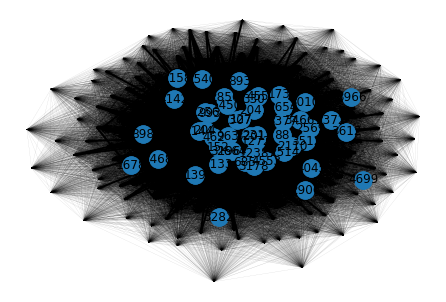

In [335]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
#wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
w90 = np.percentile([d['weight'] for n1, n2, d in gDoc.edges(data = True)], 90)

edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > w90]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= w90]

gDoc.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= w90])
#gDoc.remove_nodes_from([n for n in gDoc.nodes if len(set(gDoc.neighbors(n))) >= 250]) 
gDoc.remove_nodes_from([n for n, c in docnode_centrality.items() if c < ecentrality_99]) 
gDoc.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.1)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [333]:
print(len(reddit_submissions_min_select.iloc[2967]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[2967]['post_text'].strip().replace('  ', '\n'))

152 words: 
 Calexit: Leftists File Papers for 2018 Secession Referendum http://www.breitbart.com/california/2016/11/22/calexit-leftists-file-papers-2018-referendum/


In [305]:
print(len(reddit_submissions_min_select.iloc[2624]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[2624]['post_text'].strip().replace('  ', '\n'))

68 words: 
 Thoughts on Jeff Sessions as Attorney General? Thoughts Centipedes?


In [306]:
print(len(reddit_submissions_min_select.iloc[4448]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[4448]['post_text'].strip().replace('  ', '\n'))

88 words: 
 –≠—Ç–æ—Ç –¥–æ–º–µ–Ω –±—ã–ª –æ–∫–∫—É–ø–∏—Ä–æ–≤–∞–Ω –§–°–ë –ë–ª–∞–≥–æ–¥–∞—Ä—é –í–∞—Å –∑–∞ —Ç–µ—Ä–ø–µ–Ω–∏–µ[.](https://i.sli.mg/Um5dqF.png)


In [307]:
print(len(reddit_submissions_min_select.iloc[2922]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[2922]['post_text'].strip().replace('  ', '\n'))

74 words: 
 Reminder: muslims are raised from birth to deceive the infidels. [removed]


In [308]:
print(len(reddit_submissions_min_select.iloc[518]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[518]['post_text'].strip().replace('  ', '\n'))

201 words: 
 Polls starting to trickle out in various states indicating a Trump surge!! Ohio: http://archive.is/nLuBm

North Carolina: http://archive.is/QPw69

We have the momentum!
Keep the faith!!
Stay strong!!


In [336]:
print(len(reddit_submissions_min_select.iloc[107]['post_text']),"words:","\n",reddit_submissions_min_select.iloc[107]['post_text'].strip().replace('  ', '\n'))

781 words: 
 Need help replying to a comment about voter fraud. Any help would be appreciated. I have been involved in a discussion about voter fraud. Everything from the argument 'only one in a billion cast ballots are found to be fraudulent' to 'there are more Republican Attorneys General and they wouldn't let Hillary win' has been posted in the thread. I have been able to hold my own. Then, I received this comment that has left me a little stumped as to how to reply. I do not wish to come across as uninformed. Thanks to everyone in advance.


"Voter fraud exists! Just like other crimes exist. The false equivalence comes in when claims are made that the level of fraud rises to change the outcome of elections. It is not even close. It does give some the fear needed to control them."


### Word-Network

In [9]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 25879
Number of edges: 9743971
Average degree: 753.0408


In [10]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
word80 = np.percentile([d['weight'] for n1, n2, d in gWord.edges(data = True)], 80)
print("wMean: {}, w80%le: {}".format(wMean, word80))

wMean: 1.8137933702799403, w80%le: 2.0


In [27]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 70])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [28]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 147
Number of edges: 303
Average degree:   4.1224


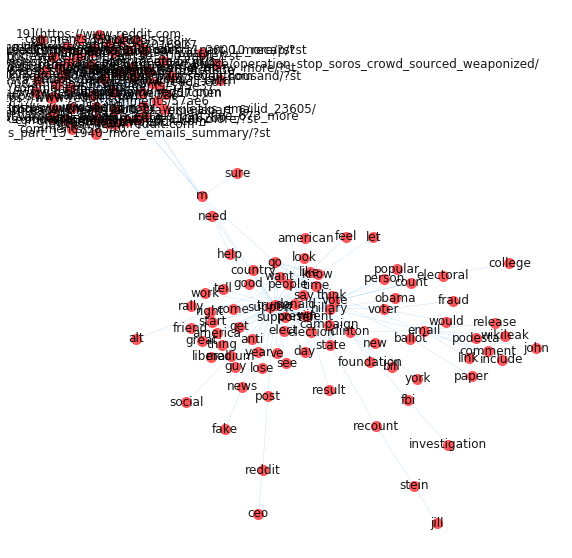

In [29]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [30]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [31]:
c

[frozenset({'/r',
            '10.1](https://www.reddit.com',
            '10.2](https://www.reddit.com',
            '11](https://www.reddit.com',
            '13](https://www.reddit.com',
            '14](https://www.reddit.com',
            '15](https://www.reddit.com',
            '18](https://www.reddit.com',
            '19](https://www.reddit.com',
            '20](https://www.reddit.com',
            '5](https://www.reddit.com',
            '6](https://www.reddit.com',
            '7](https://www.reddit.com',
            '8](https://www.reddit.com',
            '9](https://www.reddit.com',
            '=',
            'alt',
            'america',
            'american',
            'anti',
            'ballot',
            'bill',
            'campaign',
            'catch',
            'ceo',
            'clinton',
            'college',
            'come',
            'comment',
            'comments/575e37',
            'comments/57ae6',
            'comments/57gnen',
     

In [32]:
giant = nx.Graph(giant)

giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 147
Number of edges: 303
Average degree:   4.1224


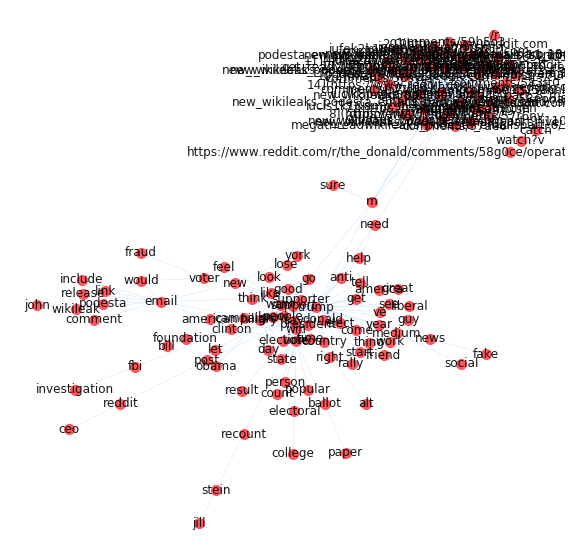

In [33]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We see that these are mostly election-related words, as is to be expected. What's more interesting is the clusters of words -- Wikileaks, Podesta, release are linked to email, whoch then link to Clinton closer to the center. All big themes of the news cycle (unfortunately). Fake news and Social media is grouped together on the let, moving away from the center.

In [34]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

hillary, trump, vote, people, go, know


In [35]:
trumpNeighbors = giant.neighbors('trump')
g_trump = giant.subgraph(trumpNeighbors)
print(nx.info(g_trump))

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 119
Average degree:   4.6667


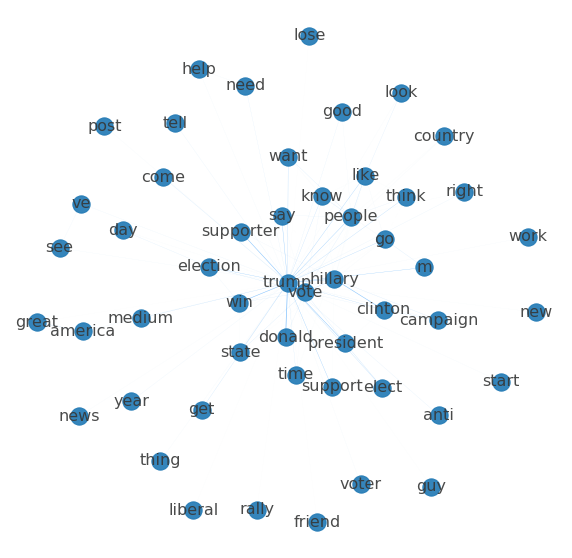

In [36]:
layout_trump = nx.spring_layout(g_trump, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
nx.draw(g_trump, ax = ax, pos = layout_trump, labels = {n:n for n in g_trump.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_trump.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [37]:
trumpWNeighbors = gWord.neighbors('trump')
trumpWNeighborsPlus1 = set(trumpWNeighbors)
for n in trumpWNeighbors:
    trumpWNeighborsPlus1 |= set(giant.neighbors(n))
    
for x in trumpWNeighborsPlus1:
    print(x)

comments/59hwqu
offended
xd
ignore
day](https://www.youtube.com
refuge
grandma
discourage
deserving
12:57
endorsements](https://i.sli.mg
announcer
norris
pal
entrench
a_damn_idiot
israeli
flake
appreciation
congress
abusive
lets_take_down_the_clinton_foundation_now_maga3x/
likely
powell
swift
letter
nonviolent
masse
futurenactiveaccount
@denpostdana
baseball
@pastorkdub
imbue
https://www.reddit.com/r/the_donald/comments/5eu1be/action_required_recount_supervisors_volunteers/dafnlr2/?st=ivyfobde&amp;sh=2489676f
palmieri
it_takes_a_village
slow
disgruntle
conversation
emcmullin@cendyn.com
dollarsor
@k4cmusic
sophistry
purposefully
j3e_y9bc7h
psychopathy
mayor
indonesian
darth
russian_discord
onwards
federal_funds_rate_1954_thru_2009_effective.svg.png
contexts
frustrate
question
catch
deranged
anthem
dictator
story?id=32540233
sub
character
springsteen
v.
threaten
marker
gadget
takeaway
reconciliation
damaging
gradually
bow
plethora
@westridgechurch
taste
wjc
gif
12/16/98
care
cuckold
unli

va
programmer
cease
flood
commentator
bundlers.](https://wikileaks.org
totem
@lifenaple
fandango](https://www.youtube.com
@roisinamcd
scrap
reminiscent
@paullowejr
fml
cashill
backyard
notwithstanding
ideologue
unusual
bite
oicmst4?t=36s
defeat
exoneration
jcorsi@worldnetdaily.com
vez
repulic
seventh
regardless
admin
wsj
accustomed
raqqa
disassembly
https://twitter.com/mfministriesnv
https://www.google.com/search?q=david+evan+mcmullin
piss
glance
mexico
bounty
elderly
induced
@alwaysfab
@briankingston
sheriff
instincts](http://www.politico.com
prostitution](http://2static.fjcdn.com
evil
life
groundwork
adolf
witty
spazze
unapologetic
mcauliffe
moon
cohn
guest
favorability
nick
@jimperdue
archived
11-d
vid
genre
involve
series
kanye
archive.is
http://www.electograph.com/2016/11/austria-october-2016-akonsult-poll.html
u?t=8s
constraint
@pastorbnlcc
illogical
act](https://en.wikipedia.org
@churchforthug
gzippy
isl
arch
supportive
en/1/13
interject
deyo
xweiqukbm_k
https://youtu.be/zergz09

roman
tantrum
commotion
substantially
http://radaronline.com/celebrity-news/kim-kardashian-robbed-gunpoint-security-bodyguards-secret-service-armed-paranoid-kuwtk/
stewarde
http://www.glamour.com/story/kim-kardashian-recovered-jewelry
warpath
http://www.infowars.com/contact/
https://www.facebook.com/unitycenterreno
gentle
plastic
cheese_8eaafc_6076462.jpg
hear
interconnect
jabba
altercation
shield
impressed
gt;4
infringement
partners
counted.](http://empowertexans.com
gt;http://www.zerohedge.com
way
spite
continue(d
crappy
corrupting
lateral
support
http://www.podesta.com/talent
ridiculously
https://www.youtube.com/watch?v=l1bc9uevwdm
sounder
democrats
maternity
infusion
house'](https://www.theguardian.com
shitposting_around_the_world_election_countdown/
unpreparedness
wife
graph
blurb
hellbent
eoyma_8dfm0
incoming
/photos
shocker
general!](https://www.reddit.com
reciprocate
q
housewife
110k
succinctly
successful
deliverer
century
symon√©
@renovationatl
ri
diehard
wireless
cheese_73401

egg
donnini
closet
obama
referendum
sidebar
yx5w0p
www.gaclv.org
hillaryclinton
kohn
nazis
cheese_0647c6_6076462.jpg
rosary
station
mut
shockingly
clear
21k
pan
scotland
cher](https://en.wikipedia.org
@davestone920
twwnmtbegim
video/2016/12/07
investigation
orphan
cliton
|[9:5](https://quran.com/9:5)|
wikipedia
sufficient
taylor
http://donaldjtrump.com/debate
world
flock
neighborhood
peace
previous
running
dsands@washingtontimes.com
radar
connection](http://2static.fjcdn.com
lion
ponzi
jgusf
small
constrain
here]https://www.periscope.tv
emails
neera
ww2](http://www.npr.org/2015/12/27/461173027
sabato
shitty
appalling
henceforth
3rd
stratfor
vested
behest
market
wreak
reconsider
cre
submissions
in~~
wan
brown
avow
particularly
https://i.sli.mg/4xjiou.png
imo
high
whistleblowing
@soulriochurch
https://www.texastribune.org/directory/dan-patrick/
ideation
@johnmullerjr
pii
reflective
flairforthegold
–ø–∞—Ä—Ç–∏—è
@newlifecolorado
gt;manusian
pertain
storm
diffuse
con
demonize
anytime
guardi

http://www.pbs.org/newshour/rundown/several-democrats-facing-2018-re-election-states-trump-carried/
g√∂k√ßek
numeric
rudy
discrimininate
@mychampcity
swung
moeon.org
mary
conviction
cent
solicit
unacademic
stand
difficulty
lib
employee
.com
comfy.](https://i.sli.mg
malevolent
stumble
iraq
harmful
9:50pm
immense
http://time.com/4572018/face-off-person-of-the-year-2016/
relentless
gtfo
disgustedformerdem
geriatric
actleverage
troop
centralized
citronaughty
lastslonger
possibility
snicker
c+c
elite
vicious
almeda
constantly
uss
humanity
@keithmohr
hahahahah
subthread
blind
traumatize
http://www.thenewamerican.com/tech/environment/item/20008-now-hiring-rent-a-mobs-mobilizing-global-warming-activists-for-2015-action
wink
charliespiering
dickhead
ancient
chop
unpack
jamesokeefeiii
@bishopjake
steal
newsroom
nature](http://yournewswire.com
surreal
dj
shitpoating
ivanka
potentially
cranston](https://en.wikipedia.org
gunmageddon
10k
okeefe-53015c2f44b6#.pqb1piq28
days](http://blog.constitutionc

In [38]:
g_trump2 = giant.subgraph(trumpWNeighborsPlus1)
giant.remove_nodes_from(list(nx.isolates(g_trump2)))
print(nx.info(g_trump2))

Name: 
Type: Graph
Number of nodes: 131
Number of edges: 249
Average degree:   3.8015


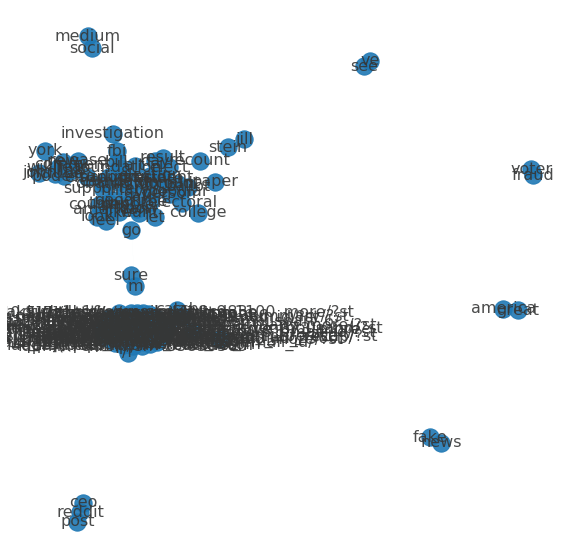

In [39]:
layout_trump2 = nx.spring_layout(g_trump2, weight='weight', iterations= 100, k = 0.6)
fig, ax = plt.subplots(figsize = (10,10))
centralities_trump2 = nx.eigenvector_centrality(g_trump2)
maxC = max(centralities_trump2.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))
nx.draw(g_trump2, ax = ax, pos = layout_trump2, labels = {n:n for n in g_trump2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_trump2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

## Exercise 2 - Network Statistics

### Eigenvector Centrality

In [67]:
ecentralities = nx.eigenvector_centrality(giant)
[ecentralities[x] for x in ['trump', 'clinton', 'stein', 'email', 'fbi', 'investigation', 'fake', 'recount']]

[0.025112435461307453,
 0.00470211650395958,
 3.067106011391709e-05,
 0.0019545268135188238,
 0.0003830208968230882,
 3.10017978511493e-05,
 0.00016542965542649469,
 0.0003764525853129879]

In [68]:
max(ecentralities.items(), key = lambda x : x[1])

('the_donald', 0.4925297550770407)

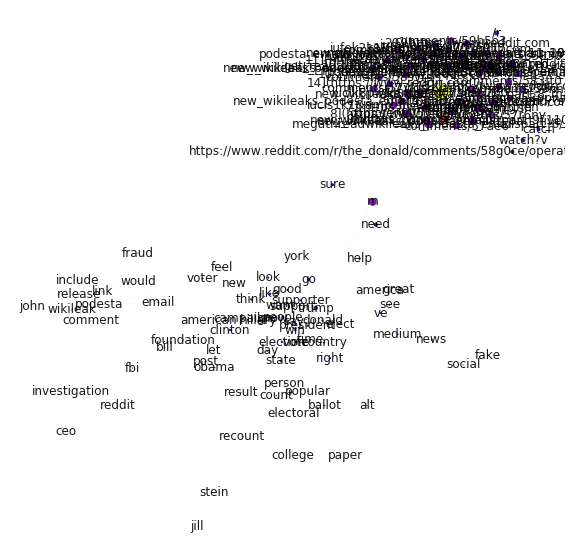

In [70]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ecentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ecentralities[n] / maxC for n in giant.nodes],
        node_size = [ecentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

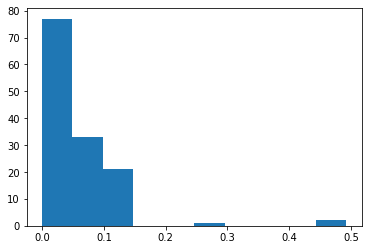

In [71]:
plt.hist(list(ecentralities.values()))
plt.show()

In [72]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[:25]

[('the_donald', 0.4925297550770407),
 ('r', 0.48930961275862916),
 ('=', 0.2851225573626677),
 ('m', 0.11580905401922331),
 ('iu77f1fk&amp;sh=6a131386', 0.1024436427367865),
 ('iucls1k1&amp;sh=3b8cd83e', 0.1024436427367865),
 ('f9d58ab5', 0.1024436427367865),
 ('5](https://www.reddit.com', 0.1024436427367865),
 ('new_wikileaks_podesta_emails_part_9_1100_more/?st', 0.1024436427367865),
 ('comments/57m9ty', 0.1024436427367865),
 ('iuclk8pw&amp;sh=71ca62b0', 0.1024436427367865),
 ('iub09hbn&amp;sh', 0.1024436427367865),
 ('new_wikileaks_podesta_emails_part_five_673_more', 0.1024436427367865),
 ('megathreadwikileaks_podesta_emailspart_6/', 0.1024436427367865),
 ('new_wikileaks_podesta_emails_part_seventhousand/?st', 0.1024436427367865),
 ('comments/57ae6', 0.1024436427367865),
 ('new_wikileaks_podesta_emails_part_8_many_more/?st', 0.1024436427367865),
 ('comments/575e37', 0.1024436427367865),
 ('comments/57r6nv', 0.1024436427367865),
 ('comments/57gnen', 0.1024436427367865),
 ('8](https://

In [73]:
sorted(ecentralities.items(), key = lambda x: x[1], reverse = True)[-25:]

[('fbi', 0.0003830208968230882),
 ('foundation', 0.00038051095858898307),
 ('bill', 0.00038051095858898307),
 ('recount', 0.0003764525853129879),
 ('result', 0.0003604235577788628),
 ('would', 0.00032577232328085835),
 ('alt', 0.00022158601023429748),
 ('reddit', 0.00019749645326066595),
 ('york', 0.00019413414710536673),
 ('fraud', 0.00016757824294624465),
 ('social', 0.00016542965542649469),
 ('fake', 0.00016542965542649469),
 ('podesta', 0.00015923807669577053),
 ('link', 0.00015819408033461365),
 ('wikileak', 0.00015819408033461365),
 ('release', 0.00015819408033461365),
 ('include', 0.00015819408033461365),
 ('comment', 0.00015819408033461365),
 ('college', 5.8951700837222375e-05),
 ('paper', 5.8951700837222375e-05),
 ('investigation', 3.10017978511493e-05),
 ('stein', 3.067106011391709e-05),
 ('ceo', 1.598070553386308e-05),
 ('john', 1.2891554830450134e-05),
 ('jill', 2.483152843353002e-06)]

Eigenvector centrality here shows us the extremely self-referential nature of the 'r/The_Donald' subreddit in the weeks leading up to and after the election -- lots of hyperlinks to other threads and articles. Their high eigenvector centrality values suggest that they were cross-posted across different submissions by users, linking important themes. It might make sense for me to extract all links into a separate bi-partite network to capture this behaviour. (To-do for final project)

Additionally, I can see a bunch of salient topics/words mentioned here -- wikileaks, the Podesta controversy, Clinton's emails and the promised FBI investigation. All of these were salient, driving points in the media in the run-up to the election, and this is refleted in the submissions here.

### Degree Centrality

In [53]:
dcentralities = nx.degree_centrality(giant)
[dcentralities[x] for x in ['trump', 'clinton', 'stein', 'email', 'fbi', 'investigation', 'fake', 'recount']]

[0.2932330827067669,
 0.08270676691729323,
 0.015037593984962405,
 0.09774436090225563,
 0.015037593984962405,
 0.007518796992481203,
 0.007518796992481203,
 0.03007518796992481]

In [44]:
max(dcentralities.items(), key = lambda x : x[1])

('the_donald', 0.44360902255639095)

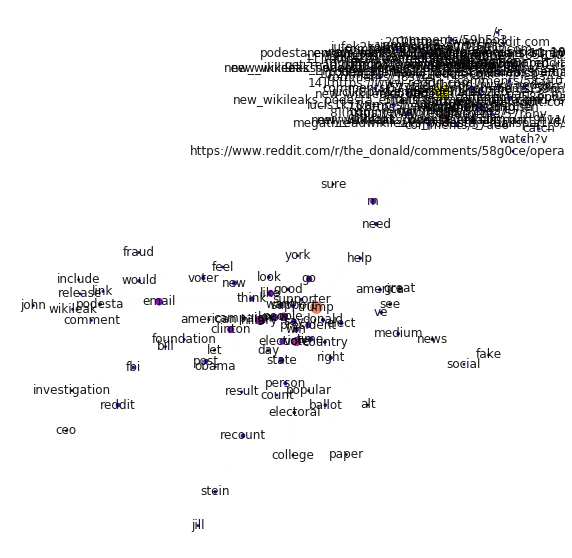

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

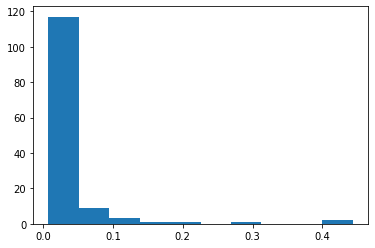

In [47]:
plt.hist(list(dcentralities.values()))
plt.show()

Extremely sharp fall-off here.

In [50]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:25]

[('the_donald', 0.44360902255639095),
 ('r', 0.43609022556390975),
 ('trump', 0.2932330827067669),
 ('=', 0.21804511278195488),
 ('vote', 0.15037593984962405),
 ('hillary', 0.13533834586466165),
 ('people', 0.12030075187969924),
 ('email', 0.09774436090225563),
 ('clinton', 0.08270676691729323),
 ('like', 0.07518796992481203),
 ('know', 0.07518796992481203),
 ('go', 0.06015037593984962),
 ('m', 0.06015037593984962),
 ('election', 0.06015037593984962),
 ('president', 0.05263157894736842),
 ('win', 0.05263157894736842),
 ('state', 0.05263157894736842),
 ('say', 0.045112781954887216),
 ('think', 0.03759398496240601),
 ('time', 0.03759398496240601),
 ('new', 0.03759398496240601),
 ('want', 0.03759398496240601),
 ('reddit', 0.03007518796992481),
 ('post', 0.03007518796992481),
 ('recount', 0.03007518796992481)]

In [52]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-25:]

[('jill', 0.007518796992481203),
 ('college', 0.007518796992481203),
 ('release', 0.007518796992481203),
 ('result', 0.007518796992481203),
 ('watch?v', 0.007518796992481203),
 ('sure', 0.007518796992481203),
 ('alt', 0.007518796992481203),
 ('bill', 0.007518796992481203),
 ('paper', 0.007518796992481203),
 ('catch', 0.007518796992481203),
 ('ceo', 0.007518796992481203),
 ('feel', 0.007518796992481203),
 ('count', 0.007518796992481203),
 ('john', 0.007518796992481203),
 ('social', 0.007518796992481203),
 ('let', 0.007518796992481203),
 ('fake', 0.007518796992481203),
 ('popular', 0.007518796992481203),
 ('obama', 0.007518796992481203),
 ('investigation', 0.007518796992481203),
 ('https://www.reddit.com/r/the_donald/comments/58g0ce/operation_stop_soros_crowd_sourced_weaponized/',
  0.007518796992481203),
 ('include', 0.007518796992481203),
 ('comment', 0.007518796992481203),
 ('american', 0.007518796992481203),
 ('york', 0.007518796992481203)]

Similar trends in word-clustering as Eigenvector centrality, but links seem to be lower ranked.

### Betweenness Centrality

In [54]:
bcentralities = nx.betweenness.betweenness_centrality(giant)
[bcentralities[x] for x in ['trump', 'clinton', 'stein', 'email', 'fbi', 'investigation', 'fake', 'recount']]

[0.5762940162290813,
 0.08026076604340447,
 0.015037593984962405,
 0.10694159641528064,
 0.015037593984962405,
 0.0,
 0.0,
 0.02984734563681932]

In [55]:
max(bcentralities.items(), key = lambda x : x[1])

('trump', 0.5762940162290813)

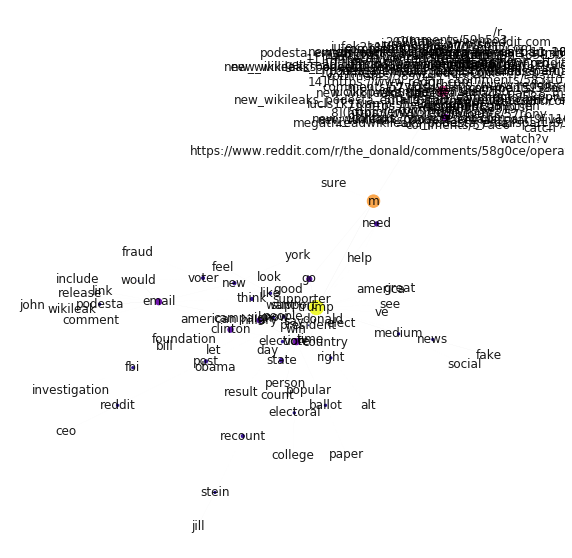

In [63]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities[n] / maxC for n in giant.nodes],
        node_size = [bcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

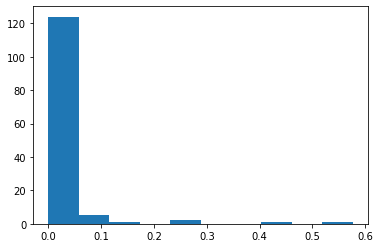

In [64]:
plt.hist(list(bcentralities.values()))
plt.show()

In [65]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[:25]

[('trump', 0.5762940162290813),
 ('m', 0.44758156706208674),
 ('the_donald', 0.27991712851589795),
 ('r', 0.2648795345309356),
 ('=', 0.14009739026827198),
 ('vote', 0.11039367900270156),
 ('email', 0.10694159641528064),
 ('clinton', 0.08026076604340447),
 ('go', 0.07399377033690091),
 ('hillary', 0.06895724652047272),
 ('need', 0.052760196437571655),
 ('state', 0.04442925495557074),
 ('post', 0.02984734563681932),
 ('recount', 0.02984734563681932),
 ('new', 0.029540892767140205),
 ('think', 0.026597288183070847),
 ('voter', 0.026106934001670835),
 ('people', 0.023407273595243517),
 ('know', 0.01602599572524385),
 ('like', 0.015899597478544848),
 ('election', 0.015846434267486897),
 ('podesta', 0.015037593984962405),
 ('news', 0.015037593984962405),
 ('reddit', 0.015037593984962405),
 ('medium', 0.015037593984962405)]

In [66]:
sorted(bcentralities.items(), key = lambda x: x[1], reverse = True)[-25:]

[('obama', 0.0),
 ('investigation', 0.0),
 ('comments/57gnen', 0.0),
 ('ve', 0.0),
 ('8](https://www.reddit.com', 0.0),
 ('iumnbqhj&amp;sh', 0.0),
 ('https://www.reddit.com/r/the_donald/comments/58g0ce/operation_stop_soros_crowd_sourced_weaponized/',
  0.0),
 ('include', 0.0),
 ('podesta_emails_part_13_1940_more_emails_summary/?st', 0.0),
 ('help', 0.0),
 ('18](https://www.reddit.com', 0.0),
 ('donald', 0.0),
 ('want', 0.0),
 ('comment', 0.0),
 ('iuphiik7&amp;sh=65830560', 0.0),
 ('comments/57ykjs', 0.0),
 ('6](https://www.reddit.com', 0.0),
 ('7](https://www.reddit.com', 0.0),
 ('new_wikileaks_podesta_emails_part_19_email_id/', 0.0),
 ('9](https://www.reddit.com', 0.0),
 ('american', 0.0),
 ('20](https://www.reddit.com', 0.0),
 ('york', 0.0),
 ('comments/59nnhc', 0.0),
 ('f391c605', 0.0)]

Results almost identical to Degree Centrality.

### Closeness Centrality

In [75]:
ccentralities = nx.closeness_centrality(giant)
[ccentralities[x] for x in ['trump', 'clinton', 'stein', 'email', 'fbi', 'investigation', 'fake', 'recount']]

[0.4418604651162791,
 0.33585858585858586,
 0.1996996996996997,
 0.27422680412371137,
 0.25285171102661597,
 0.20212765957446807,
 0.23623445825932504,
 0.24813432835820895]

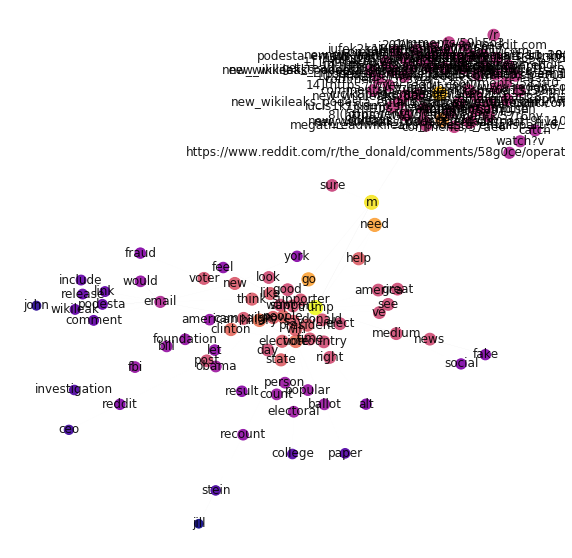

In [80]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ccentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [ccentralities[n] / maxC for n in giant.nodes],
        node_size = [ccentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

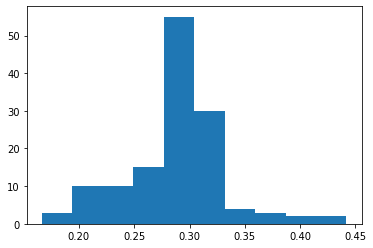

In [239]:
plt.hist(list(ccentralities.values()))
plt.show()

In [81]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[:25]

[('trump', 0.4418604651162791),
 ('m', 0.4290322580645161),
 ('the_donald', 0.4054878048780488),
 ('r', 0.40425531914893614),
 ('go', 0.38439306358381503),
 ('need', 0.382183908045977),
 ('=', 0.37254901960784315),
 ('hillary', 0.3472584856396867),
 ('vote', 0.3427835051546392),
 ('clinton', 0.33585858585858586),
 ('people', 0.3325),
 ('know', 0.32678132678132676),
 ('state', 0.32598039215686275),
 ('help', 0.32598039215686275),
 ('win', 0.3251833740831296),
 ('president', 0.32439024390243903),
 ('think', 0.3236009732360097),
 ('election', 0.3236009732360097),
 ('say', 0.3220338983050847),
 ('like', 0.321256038647343),
 ('new', 0.321256038647343),
 ('campaign', 0.3181818181818182),
 ('voter', 0.3159144893111639),
 ('time', 0.3144208037825059),
 ('supporter', 0.3144208037825059)]

In [82]:
sorted(ccentralities.items(), key = lambda x: x[1], reverse = True)[-25:]

[('bill', 0.2518939393939394),
 ('american', 0.25),
 ('recount', 0.24813432835820895),
 ('let', 0.24675324675324675),
 ('result', 0.24493554327808473),
 ('feel', 0.24358974358974358),
 ('york', 0.24358974358974358),
 ('fraud', 0.24050632911392406),
 ('reddit', 0.23792486583184258),
 ('alt', 0.23707664884135474),
 ('social', 0.23623445825932504),
 ('fake', 0.23623445825932504),
 ('podesta', 0.216260162601626),
 ('link', 0.21555915721231766),
 ('wikileak', 0.21555915721231766),
 ('release', 0.21555915721231766),
 ('include', 0.21555915721231766),
 ('comment', 0.21555915721231766),
 ('college', 0.20461538461538462),
 ('paper', 0.20461538461538462),
 ('investigation', 0.20212765957446807),
 ('stein', 0.1996996996996997),
 ('ceo', 0.19247467438494936),
 ('john', 0.17804551539491298),
 ('jill', 0.16666666666666666)]

While the results seem similar, the centrality distribution is markedly different, but that's due to the definition of Closeness Centrality.

### Filtering by Centrality Scores

In [83]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [91]:
giant_filtered50 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=50)
print(nx.info(giant_filtered50))

Total number of nodes(after filtering) in the graph is 50
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 128
Average degree:   5.1200


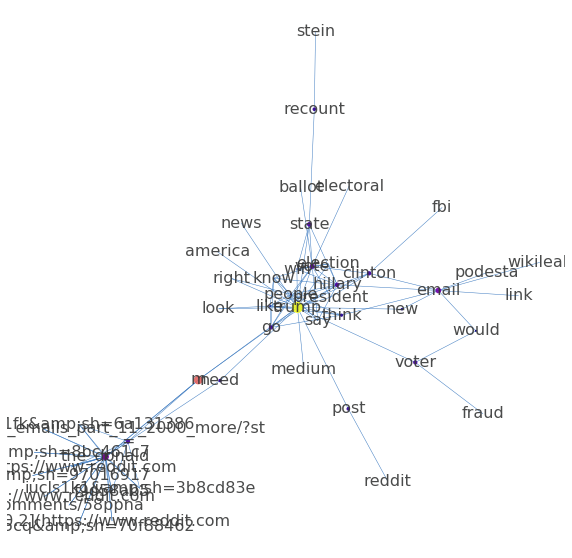

In [92]:
layout_giant_filtered50 = nx.spring_layout(giant_filtered50, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant50 = nx.betweenness_centrality(giant_filtered50)
maxC = max(centralities_giant50.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered50, ax = ax, pos = layout_giant_filtered50, labels = {n: n for n in giant_filtered50.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant50[n] / maxC for n in giant_filtered50.nodes],
        node_size = [centralities_giant50[n] / maxC * 100 for n in giant_filtered50.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

### Global Statistics

In [93]:
nx.density(giant)

0.03254404668387386

In [94]:
np.mean([v for w,v in nx.degree(giant)])

4.3283582089552235

In [95]:
nx.diameter(giant)

7

These statistics reveal that the word-network is fairly densely connected, with similar words being used repeatedly. 

## Exercise 3 - PoS-based Networks

In [96]:
import spacy
nlp = spacy.load('en')

def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

### Noun networks

In [98]:
#gNN = posCooccurrence(reddit_submissions_min_select['normalized_sents'].sum(), 'NN')

#with open('donald_t8_gNN.pkl', 'wb') as f:
#    pickle.dump(gNN, f)

In [267]:
with open('donald_t8_gNN.pkl', 'rb') as f:
    gNN = pickle.load(f)

In [268]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 7419
Number of edges: 94196
Average degree:  25.3932


In [269]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 500]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 272
Average degree:  23.6522


In [270]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 50])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 15
Average degree:   1.3043


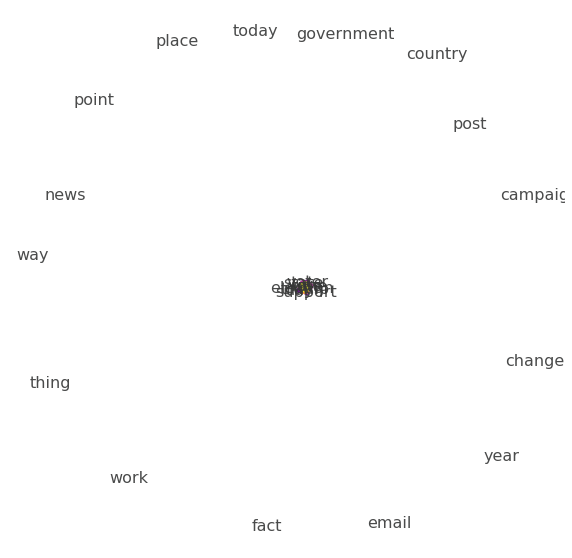

In [271]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Mostly keywords from the election news-cycle.

### Noun-Verb pairs

In [147]:
gNV = posCooccurrence(reddit_submissions_min_select['normalized_sents'].sum(), 'NN', 'VB')

with open('donald_t8_gNV.pkl', 'wb') as f:
    pickle.dump(gNV, f)

In [279]:
with open('donald_t8_gNV.pkl', 'rb') as f:
    gNV = pickle.load(f)

In [280]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 7792
Number of edges: 132457
Average degree:  33.9982


In [281]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 7792
Number of edges: 37852
Average degree:   9.7156


In [282]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 5])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 10])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 37
Number of edges: 223
Average degree:  12.0541


/home/mathew/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


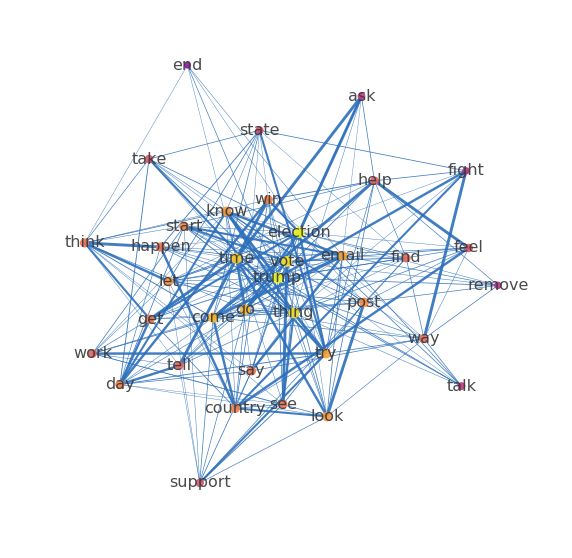

In [283]:
# Would've been better as a bipartite graph
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality_numpy(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

It would've been better as a bi-partite graph, because this layout mixes nouns and verbs. I can't really identify salient themes here.

#### Ego-network for 'trump' (2-hops)

In [190]:
trumpNeighbors_ego = set(gNV.neighbors('trump'))
trumpNeighborsPlus1_ego = set(trumpNeighbors_ego)
for n in trumpNeighbors_ego:
    trumpNeighborsPlus1_ego |= set(gNV.neighbors(n))
    
gNV_trumpEgo = gNV.subgraph(trumpNeighborsPlus1_ego)
print(nx.info(gNV_trumpEgo))

Name: 
Type: Graph
Number of nodes: 36
Number of edges: 223
Average degree:  12.3889


In [191]:
sorted(nx.degree_centrality(gNV_trumpEgo).items(), key = lambda x: x[1], reverse = True)[:25]

[('election', 0.6),
 ('trump', 0.6),
 ('thing', 0.5428571428571428),
 ('vote', 0.5428571428571428),
 ('time', 0.5142857142857142),
 ('email', 0.45714285714285713),
 ('come', 0.42857142857142855),
 ('go', 0.42857142857142855),
 ('post', 0.39999999999999997),
 ('try', 0.39999999999999997),
 ('look', 0.37142857142857144),
 ('think', 0.37142857142857144),
 ('know', 0.37142857142857144),
 ('country', 0.37142857142857144),
 ('let', 0.37142857142857144),
 ('day', 0.37142857142857144),
 ('way', 0.37142857142857144),
 ('win', 0.34285714285714286),
 ('start', 0.34285714285714286),
 ('help', 0.34285714285714286),
 ('say', 0.3142857142857143),
 ('find', 0.3142857142857143),
 ('get', 0.3142857142857143),
 ('see', 0.3142857142857143),
 ('happen', 0.3142857142857143)]

In [192]:
sorted(nx.eigenvector_centrality(gNV_trumpEgo).items(), key = lambda x: x[1], reverse = True)[:25]

[('election', 0.2381659111658372),
 ('trump', 0.2381659111658372),
 ('vote', 0.22501108494060282),
 ('thing', 0.22459830641783668),
 ('time', 0.2119191432709697),
 ('come', 0.20186097453839294),
 ('go', 0.20186097453839294),
 ('try', 0.19001142205218557),
 ('email', 0.18645807429371156),
 ('know', 0.18135792200465514),
 ('look', 0.18060296509599433),
 ('let', 0.17781946116893077),
 ('post', 0.1736098051965673),
 ('start', 0.16862791639037902),
 ('win', 0.16711708760277416),
 ('day', 0.16587924355392328),
 ('country', 0.1630014330963816),
 ('get', 0.16041093909785165),
 ('say', 0.1578187179785311),
 ('happen', 0.15740481792518995),
 ('think', 0.15721001205689353),
 ('see', 0.1561791992409523),
 ('way', 0.1530835705336513),
 ('find', 0.14924915909676054),
 ('tell', 0.14486154984636307)]

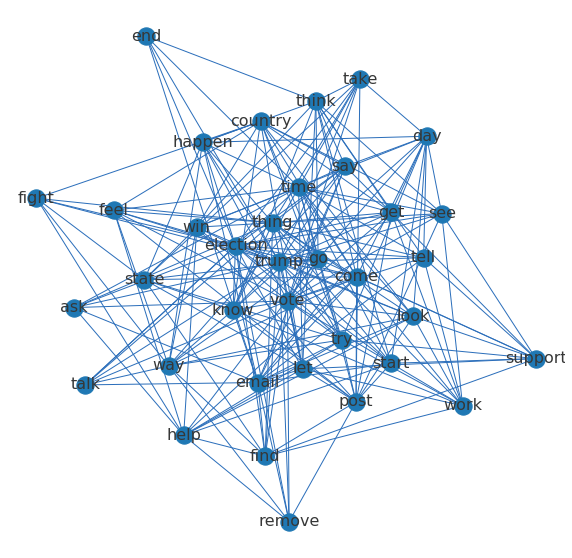

In [193]:
layout_trumpEgo = nx.spring_layout(gNV_trumpEgo, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_trumpEgo, ax = ax, pos = layout_trumpEgo, labels = {n: n for n in gNV_trumpEgo.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

### Noun-Adjective pairs

In [150]:
gNJ = posCooccurrence(reddit_submissions_min_select['normalized_sents'].sum(), 'NN', 'JJ')

with open('donald_t8_gNJ.pkl', 'wb') as f:
    pickle.dump(gNJ, f)

In [ ]:
with open('donald_t8_gNJ.pkl', 'rb') as f:
    gNJ = pickle.load(f)

In [151]:
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 9938
Number of edges: 177109
Average degree:  35.6428


In [206]:
gNJ_filtered50 = filterWords(gNJ, minWeight=3, filter_='eigenvector', rule='number', value_of_rule=50)
print(nx.info(gNJ_filtered50))

Total number of nodes(after filtering) in the graph is 20
Name: 
Type: Graph
Number of nodes: 20
Number of edges: 199
Average degree:  19.9000


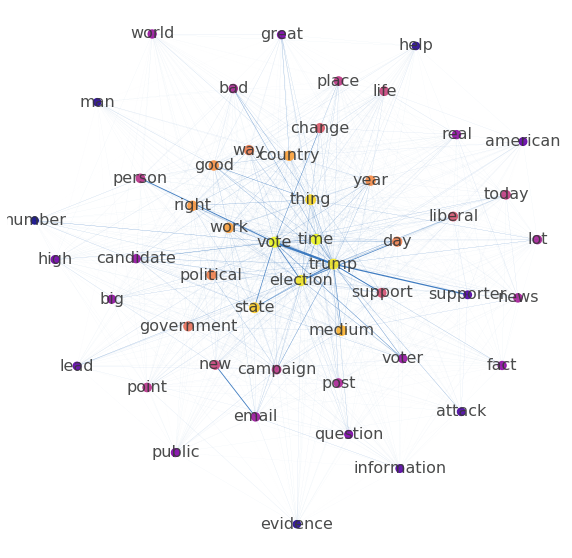

In [209]:
layout_NJ_filtered50 = nx.spring_layout(gNJ_filtered50, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
ecentralities_nj50 = nx.eigenvector_centrality_numpy(gNJ_filtered50)
maxC = max(ecentralities_nj50.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered50, ax = ax, pos = layout_NJ_filtered50, labels = {n: n for n in gNJ_filtered50.nodes()},
        alpha = .9, 
        #width = .5,
        width=[(d['weight'] - minWeight + .5) / maxWeight for n1, n2, d in gNJ_filtered50.edges(data = True)], 
        node_color = [ecentralities_nj50[n] / maxC for n in gNJ_filtered50.nodes],
        node_size = [ecentralities_nj50[n] / maxC * 100 for n in gNJ_filtered50.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Similar issue again -- I see too many nouns and very few adjectives to draw meaningful conclusions.

## Exercise 4 -- Agent Networks & Influence

My current dataset doesn't have any explicit agent markers, therefore this segment isn't implemented. I will be using this method on the larger corpus which includes comments.

In [229]:
reddit_submissions_min_select['tokenized_words'] = reddit_submissions_min_select['post_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))


In [230]:
reddit_submissions_min_select['tokenized_words'].head()

id
58cvsk    [It, Is, Perfectly, Legal, For, The, Media, To...
58cz8j    [Why, does, n't, Bernie, just, endorse, Trump,...
58czfz    [I, 'm, Canadian, and, want, to, watch, be, de...
58d18m    [Is, this, 4, Chan, thing, happening, Last, ni...
58d1zt    [Is, michelle, obama, a, man, I, am, just, hea...
Name: tokenized_words, dtype: object

In [237]:
characters = {}
for token in reddit_submissions_min_select['tokenized_words']:
    #print(token)
    if token[:3] == '/u/':
        print(token)
        # all characters or actions start with @, so we add that to character
        if token[3:] not in characters:
            characters[token[2:]] = 0
        if token[3:] in characters:
            characters[token[2:]] += 1

In [238]:
len(characters)

0